# Variational sparse Bayesian linear regression

This notebook is a follow-up of the homework on Bayesian regression with linear basis function models. It is assumed that you have done this homework (actually, you will need the EM algorithm implemented in the homework).

To help you answering the questions in this notebook, you can have a look to the following references: 

- D. G. Tzikas et al., [The variational approximation for Bayesian inference](http://www.ssp.ece.upatras.gr/downloads/articles/galatsanos2008_4.pdf), IEEE Signal Processing Magazine, 2008 (especially pages 9 and 10).

- C. M. Bishop & M. E. Tipping, [Variational relevance vector machines](https://arxiv.org/pdf/1301.3838.pdf), in Proceedings of the sixteenth conference on Uncertainty in Artificial Intelligence (UAI), 2000.

- Section 2.2 of Thomas Buchgraber [Ph.D. Thesis](https://www2.spsc.tugraz.at/www-archive/downloads/phdthesis-buchgraber_online.pdf) from Graz University of Technology, Austria.


## Likelihood model

We first recall the observation model for Bayesian linear regression (see the homework for more details). 

We consider a dataset of $N$ training samples $\{(x_i, t_i) \in \mathbb{R}^2\}_{i=1}^N$ where

$$t_i = \sum_{j=0}^{M-1}{w_j \phi_j(x_i)} + \epsilon_i = \mathbf{w}^\top \boldsymbol\phi(x_i) + \epsilon_i, \qquad i \in \{1,...,N\},$$

with 

- $\phi_0(x_i) = 1$,


- $\epsilon_i \overset{i.i.d}{\sim} \mathcal{N}(0, \beta^{-1})$, 


- $\boldsymbol\phi(x_i) = [\phi_0(x_i), ..., \phi_M(x_i)]^\top \in \mathbb{R}^M$, 


- $\mathbf{w} = [w_0, ..., w_M]^\top \in \mathbb{R}^M$.

This linear regression model with basis functions can be rewritten in matrix form as follows:

$$ \mathbf{t} = \boldsymbol\Phi \mathbf{w} + \boldsymbol\epsilon, $$

where

- $\mathbf{t} = [t_1, ..., t_N]^\top \in \mathbb{R}^N$,


- $\boldsymbol\epsilon = [\epsilon_1, ..., \epsilon_N]^\top \in \mathbb{R}^N$ and $\boldsymbol\epsilon \sim \mathcal{N}(0, \beta^{-1}\mathbf{I})$,


- and the *design matrix* $\boldsymbol\Phi \in \mathbb{R}^{N \times M}$ is defined as

$$
\boldsymbol\Phi = 
\begin{pmatrix}
\phi_0(x_1) &  \phi_1(x_1) & \cdots & \phi_{M-1}(x_1) \\ 
\phi_0(x_2) &  \phi_1(x_2) & \cdots & \phi_{M-1}(x_2) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_0(x_N) &  \phi_1(x_N) & \cdots & \phi_{M-1}(x_N)
\end{pmatrix}.
$$

Due to the presence of the additive Gaussian noise $\boldsymbol\epsilon$, the likelihood model is given by:

$$ p(\mathbf{t} \lvert \mathbf{w}, \beta) = \mathcal{N}(\mathbf{t}; \boldsymbol\Phi \mathbf{w}, \beta^{-1} \mathbf{I}), $$ 

where for better readibility we write $p(\mathbf{t} \lvert \mathbf{w}, \beta)$ instead of $p(\mathbf{t} \lvert \mathbf{x}, \mathbf{w}, \beta)$, i.e. we omit to denote the input vector $\mathbf{x} = [x_1, ..., x_N]^\top \in \mathbb{R}^N$.

As suggested by the variables after the conditioning bar in this likelihood model, we consider both $\mathbf{w}$ and $\beta$ as *latent random variables*, for which we need to define priors.

## Priors

**Prior over $\mathbf{w}$** 

For a Bayesian treatment of linear regression we need a prior probability distribution over model parameters $\mathbf{w}$. In the homework, we were using a stationary Gaussian prior distribution for the weights of the linear model. By stationary we mean that all the weights $w_j$, $j \in \{1,...,M\}$ were independent and had the same Gaussian prior $\mathcal{N}(0, \alpha^{-1})$, we say that they are identically distributed.

However, in many situations, it is important to allow the model to be more flexible. For this reason, a non-stationary Gaussian prior distribution with a distinct precision $\alpha_j$ for each weight will be considered here:

$$ p(\mathbf{w} \lvert \boldsymbol\alpha) = \prod_{j=1}^J \mathcal{N}(w_j; 0, \alpha_j^{-1}) = \mathcal{N}(\mathbf{w}; 0, \text{diag}(\boldsymbol\alpha)^{-1}).$$

Notice that the weights $w_j$ are still independent, but they are not identically distributed anymore as each weight has its own precision $\alpha_j$. In other words, the covariance matrix is diagonal but not proportional to the identity anymore.

**Prior over $\boldsymbol{\alpha}$**

We treat the above precision parameters $\alpha_j$ as i.i.d latent random variables following a [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) (the conjugate prior for the precision of the Gaussian):

$$ p(\boldsymbol\alpha; a, b) = \prod_{j=1}^J \mathcal{G}(\alpha_j; a, b).$$

**Prior over $\beta$**

Finally, the noise precision $\beta$ from the likelihood model is also considered as a latent random variable with a Gamma distribution:

$$ p(\beta; c, d) = \mathcal{G}(\beta; c, d).$$

The prior hyperparameters $a,b,c,d$ are assumed to be deterministic and known, so that they will be omitted in the following.

**Gamma distribution** 

We recall that the probability density function of a Gamma random variable $x > 0$ with shape and rate parameters $a >0$ and $b > 0$, respectively, is given by:

$$ \mathcal{G}(x; a, b) = \frac{ b^a x^{a-1} e^{-b x}}{\Gamma(a)}, $$

where $\Gamma(\cdot)$ is the [Gamma function](https://en.wikipedia.org/wiki/Gamma_function). Moreover, we have the following useful properties:

$$ \mathbb{E}[x] = \frac{a}{b}, \qquad\qquad \mathbb{E}[\ln(x)] = \psi(a) - \ln(b), $$

where $\psi(\cdot)$ is the [digamma function](https://en.wikipedia.org/wiki/Digamma_function).

**Complete-data likelihood**

The previous model correpsonds to the following factorization of the complete-data likelihood:

$$ 
\begin{aligned}
p(\mathbf{t}, \mathbf{w}, \boldsymbol\alpha, \beta) &= p(\mathbf{t} \lvert \mathbf{w}, \beta) p(\mathbf{w} \lvert \boldsymbol\alpha) p(\boldsymbol\alpha) p(\beta) \\\\
&= \mathcal{N}(\mathbf{t}; \boldsymbol\Phi \mathbf{w}, \beta^{-1} \mathbf{I}) \mathcal{N}(\mathbf{w}; 0, \text{diag}(\boldsymbol\alpha)^{-1}) \left( \prod_{j=1}^J \mathcal{G}(\alpha_j; a, b) \right) \mathcal{G}(\beta; c, d) \\\\
&= \left( \prod_{i=1}^N\mathcal{N}(t_i; \mathbf{w}^\top \boldsymbol\phi(x_i), \beta^{-1} ) \right) \left(\prod_{j=1}^J \mathcal{N}(w_j; 0, \alpha_j^{-1})\right) \left( \prod_{j=1}^J \mathcal{G}(\alpha_j; a, b) \right) \mathcal{G}(\beta; c, d).
\end{aligned}
$$

--- 

**Exercise 1**

**Q1.1**  

Summarize in one or two sentences the key differences between this model and the one in the homework notebook (in terms of what we treat as latent variables or deterministic parameters, and in terms of the priors).

**A1.1**$\alpha \text{ and } \beta$ are no longer determenistic parameters like in the homework, they are both considered as latent random variables following a Gamma distribution. So now we have 3 priors over $\mathbf{w} \text{, }\alpha \text{ and } \beta$

**Q1.2**  

Draw the Bayesian network associated with this model (using the plate notation).

**A1.2**
![]("bayesian network.png")
(You can draw it on a paper, take a picture, and import your image with ```![]("mypicture.png")```)

--- 

## Posterior

Bayesian inference requires the computation of the posterior distribution of all latent variables given the observations:

$$ p(\mathbf{w}, \boldsymbol\alpha, \beta | \mathbf{t}) = \frac{p(\mathbf{t} \lvert \mathbf{w}, \beta) p(\mathbf{w} \lvert \boldsymbol\alpha) p(\boldsymbol\alpha) p(\beta) }{p(\mathbf{t})}. $$

Unfortunately, the marginal likelihood $p(\mathbf{t}) = \int p(\mathbf{t} \lvert \mathbf{w}, \beta) p(\mathbf{w} \lvert \boldsymbol\alpha) p(\boldsymbol\alpha) p(\beta) d\mathbf{w} d\boldsymbol\alpha d\beta$ cannot be computed analytically, and therefore the posterior either. 

Therefore, we will resort to approximate Bayesian inference, and more precisely variational inference.

We define the following mean field approximation of the intractable posterior:

$$ q(\mathbf{w}, \boldsymbol\alpha, \beta) = q(\mathbf{w}) q(\boldsymbol\alpha) q(\beta). $$

---

**Exercise 2 - Finding the optimal variational distributions**

**Q2.1** - Applying the variational inference recipe seen during the lecture, give the expression of the parameters of $q^\star(\mathbf{w}) = \mathcal{N}\left(\mathbf{w} ; \boldsymbol\mu_N, \boldsymbol\Sigma_N \right)$. 

You "simply" have to develop and identify

$$ 
\begin{aligned}
\ln q^\star(\mathbf{w}) &= \mathbb{E}_{q(\boldsymbol\alpha)q(\beta)}[\ln p(\mathbf{t}, \mathbf{w}, \boldsymbol\alpha, \beta)] + cst \\\\
\end{aligned}
$$

Hint: $\boldsymbol\Sigma_N$ should depend on $\mathbb{E}_{q(\boldsymbol\alpha)}[\text{diag}\{\boldsymbol\alpha\}]$ and $\mathbb{E}_{q(\beta)}[\beta]$, and $\boldsymbol\mu_N$ should depend on $\mathbb{E}_{q(\beta)}[\beta]$. These expectations will be computed later.

**A2.1**
$$\begin{aligned}
\ln q^\star(\mathbf{w}) &= \mathbb{E}_{q(\boldsymbol\alpha)q(\beta)}[\ln p(\mathbf{t}, \mathbf{w}, \boldsymbol\alpha, \beta)] + cst \\
&= \mathbb{E}_{q(\boldsymbol\alpha)q(\beta)}[\ln p(\mathbf{t} \lvert + \ln \mathbf{w}, \beta) + \ln p(\mathbf{w} \lvert \boldsymbol\alpha) + \ln  p(\boldsymbol\alpha) p(\beta)] +cst \\
&= \mathbb{E}_{q(\boldsymbol\alpha)q(\beta)}[\ln \mathcal{N}(\mathbf{t}; \boldsymbol\Phi \mathbf{w}, \beta^{-1} \mathbf{I})+ \ln \mathcal{N}(\mathbf{w}; 0, \text{diag}(\boldsymbol\alpha)^{-1})+ \ln \prod_{j=1}^J \mathcal{G}(\alpha_j; a, b)+ \ln \mathcal{G}(\beta; c, d)] + cst \\
&= \mathbb{E}_{q(\boldsymbol\alpha)q(\beta)}[- \frac{1}{2} (\mathbf{t} - \boldsymbol\Phi \mathbf{w})^T \beta \mathbf{I} (\mathbf{t} - \boldsymbol\Phi \mathbf{w}) - \frac{1}{2} \mathbf{w}^T diag(\alpha) \mathbf{w}] + cst \\
&= -\frac{1}{2} \mathbb{E}_{q(\boldsymbol\alpha)q(\beta)}[\mathbf(t)^T \beta \mathbf{t} -\mathbf{t}^T \beta \Phi \mathbf{w}- \mathbf{w}^T \beta \Phi \mathbf{t}+ \mathbf{w}^T \Phi^T \beta \Phi \mathbf{w} +\mathbf{w}^T diag(\alpha) \mathbf{w}]+ cst \text{  ,or  } \mathbf{w}^T \beta \Phi \mathbf{t}=(\mathbf{t}^T \beta \Phi \mathbf{w})^T \text{ and it is a scalar} \\
&= -\frac{1}{2} \mathbb{E}_{q(\boldsymbol\alpha)q(\beta)}[-2 \mathbf{w}^T \Phi^T \beta \mathbf{t} +\mathbf{w}^T (\beta \Phi^T \Phi +diag(\alpha))\mathbf(w)]+ cst \\
&= \mathbf{w}^T \Phi^T \mathbb{E}_{q(\beta)}[\beta]\mathbf{t} - \frac{1}{2} \mathbf{w}^T (mathbb{E}_{q(\beta)}[\beta]\Phi^T \Phi +\mathbb{E}_{q(\boldsymbol\alpha)}[diag(\alpha)])\mathbf{w}+ cst \\
\end{aligned}$$ 

Or we have : 
$$ \ln \mathcal{N}\left(\mathbf{w} ; \boldsymbol\mu_N, \boldsymbol\Sigma_N \right) = - \frac{1}{2} \mathbf{w}^T \Sigma_N^{-1} \mathbf{w} + \mathbf{w}^T \Sigma_N^{-1} \mu_N$$ 

so by identification: 

$$\begin{aligned}
\Sigma_N^{-1}&=\mathbb{E}_{q(\beta)}[\beta]\Phi^T \Phi +\mathbb{E}_{q(\boldsymbol\alpha)}[diag(\alpha)] \\
\mu_N &= \Sigma_N \Phi^T \mathbb{E}_{q(\beta)}[\beta] \mathbf{t} 
\end{aligned}$$

**Q2.2** - Similarly, give the expression for the parameters of $q^\star(\boldsymbol\alpha) = \prod_{j=1}^M \mathcal{G}(\alpha_j; \tilde{a}, \tilde{b}_j)$. Develop and identify 

$$ 
\begin{aligned}
\ln q^\star(\boldsymbol\alpha) &= \mathbb{E}_{q(\mathbf{w})q(\beta)}[\ln p(\mathbf{t}, \mathbf{w}, \boldsymbol\alpha, \beta)] + cst \\\\
\end{aligned}
$$

Hint: $\tilde{b}_j$ should depend on $\mathbb{E}_{q(\mathbf{w})}[w_j^2]$.

**A2.2**
$$ 
\begin{aligned}
\ln q^\star(\boldsymbol\alpha) &= \mathbb{E}_{q(\mathbf{w})q(\beta)}[\ln p(\mathbf{t}, \mathbf{w}, \boldsymbol\alpha, \beta)] + cst \\
&= \mathbb{E}_{q(\mathbf{w})q(\beta)}[\ln p(\mathbf{t} \lvert + \ln \mathbf{w}, \beta) + \ln p(\mathbf{w} \lvert \boldsymbol\alpha) + \ln  p(\boldsymbol\alpha) p(\beta)]+cst \\
&= \mathbb{E}_{q(\mathbf{w})q(\beta)}[\ln \mathcal{N}(\mathbf{t}; \boldsymbol\Phi \mathbf{w}, \beta^{-1} \mathbf{I})+ \ln \prod_{j=1}^J \mathcal{N}(w_j; 0, \alpha_j^{-1}) + \ln \prod_{j=1}^J \mathcal{G}(\alpha_j; a, b)+ \ln \mathcal{G}(\beta; c, d)] + cst \\
&= \mathbb{E}_{q(\mathbf{w})q(\beta)}[ \sum_{j=1}^J \ln \mathcal{N}(w_j; 0, \alpha_j^{-1})+\sum_{j=1}^J \ln \mathcal{G}(\alpha_j; a, b)]+cst \\
&=\sum_{j=1}^J \mathbb{E}_{q(\mathbf{w})q(\beta)}[-\frac{1}{2} \ln \alpha_j -\frac{1}{2}\mathbf{w}_j^2 \alpha_j +(a-1) \ln \alpha_j -b \alpha_j] +cst \\
&= \sum_{j=1}^J[(a-1-\frac{1}{2}) \ln \alpha_j -(\frac{1}{2}\mathbb{E}_{q(\mathbf{w})}[\mathbf{w}_j^2]+b) \alpha_j]+cst \\
\end{aligned} 
$$
by identification: 
$$\begin{aligned} 
\tilde{b}_j &= \frac{1}{2}\mathbb{E}_{q(\mathbf{w})}[\mathbf{w}_j^2]+b \\
\tilde{a} &= a -\frac{1}{2}
\end{aligned} $$

**Q2.3** - Similarly, give the expression for the parameters of $q^\star(\beta) = \mathcal{G}(\beta; \tilde{c}, \tilde{d})$. Develop and identify 

$$ 
\begin{aligned}
\ln q^\star(\beta) &= \mathbb{E}_{q(\mathbf{w})q(\boldsymbol\alpha)}[\ln p(\mathbf{t}, \mathbf{w}, \boldsymbol\alpha, \beta)] + cst \\\\
\end{aligned}
$$

Hint: $\tilde{d}$ should depend on $\mathbb{E}_{q(\mathbf{w})}[ \parallel \mathbf{t} - \mathbf{\Phi} \mathbf{w} \parallel_2^2]$.

**A2.3**
$$ 
\begin{aligned}
\ln q^\star(\beta) &= \mathbb{E}_{q(\mathbf{w})q(\boldsymbol\alpha)}[\ln p(\mathbf{t}, \mathbf{w}, \boldsymbol\alpha, \beta)] + cst \\
&= \mathbb{E}_{q(\mathbf{w})q(\alpha)}[\ln p(\mathbf{t} \lvert + \ln \mathbf{w}, \beta) + \ln p(\mathbf{w} \lvert \boldsymbol\alpha) + \ln  p(\boldsymbol\alpha) p(\beta)]+cst \\
&= \mathbb{E}_{q(\mathbf{w})q(\alpha)}[\ln \mathcal{N}(\mathbf{t}; \boldsymbol\Phi \mathbf{w}, \beta^{-1} \mathbf{I})+ \ln \prod_{j=1}^J \mathcal{N}(w_j; 0, \alpha_j^{-1}) + \ln \prod_{j=1}^J \mathcal{G}(\alpha_j; a, b)+ \ln \mathcal{G}(\beta; c, d)] + cst \\
&= \mathbb{E}_{q(\mathbf{w})q(\alpha)}[-\frac{1}{2} \ln det(\beta I)- \frac{1}{2}(\mathbf{t}-\Phi \mathbf{w})^T \beta I (\mathbf{t}-\Phi \mathbf{w}) + (c-1) \ln \beta]+cst \\
&= (c-1-\frac{N}{2}) \ln \beta - (\frac{1}{2} \mathbb{E}_{q(\mathbf{w})}[ \parallel \mathbf{t} - \mathbf{\Phi} \mathbf{w} \parallel_2^2] + d) \beta + cst 
\end{aligned}
$$
by identification: 
$$ \begin{aligned}
\tilde{d}&=\frac{1}{2} \mathbb{E}_{q(\mathbf{w})}[ \parallel \mathbf{t} - \mathbf{\Phi} \mathbf{w} \parallel_2^2] + d \\
\tilde{c}&= c -\frac{N}{2}
\end{aligned}$$

**Computing the required expectations**

All the moments that you need to compute for the above variational parameters are obtained by using properties of the Gaussian and Gamma distributions:

- $\mathbb{E}_{q(\boldsymbol\alpha)}[\text{diag}\{\boldsymbol\alpha\}] = \text{diag}\{\tilde{a}/\tilde{b}_1, ..., \tilde{a}/\tilde{b}_M\}$
- $\mathbb{E}_{q(\beta)}[\beta] = \tilde{c}/\tilde{d}$
- $\mathbb{E}_{q(\mathbf{w})}[w_j^2] = [\boldsymbol\mu_N]_j^2 + [\boldsymbol\Sigma_N]_{j,j}$
- $\mathbb{E}_{q(\mathbf{w})}[ \parallel \mathbf{t} - \mathbf{\Phi} \mathbf{w} \parallel_2^2] = \parallel \mathbf{t} - \mathbf{\Phi} \boldsymbol\mu_N \parallel_2^2 + tr\left(\mathbf{\Phi} \boldsymbol\Sigma_N \mathbf{\Phi}^\top\right)$

**Evidence lower bound**

The evidence lower bound (ELBO) is here given by:

$$
\begin{aligned}
\mathcal{L}(q(\mathbf{w}), q(\boldsymbol\alpha), q(\beta)) &= \mathbb{E}_{q(\mathbf{w}) q(\boldsymbol\alpha) 
q(\beta)}\left[\ln p(\mathbf{t} \lvert \mathbf{w}, \beta) + \ln p(\mathbf{w} \lvert \boldsymbol\alpha) + \ln p(\boldsymbol\alpha) + \ln p(\beta)  \right] \\\\
&- \mathbb{E}_{q(\mathbf{w})} \left[ \ln q(\mathbf{w}) \right] - \mathbb{E}_{q(\boldsymbol\alpha)}\left[ \ln q(\boldsymbol\alpha) \right] - \mathbb{E}_{q(\beta)}\left[ \ln q(\beta)) \right] . 
\end{aligned}
$$

This is the objective function which is cyclically maximized when computing $q^\star(\mathbf{w})$, $q^\star(\boldsymbol\alpha)$ and $q^\star(\beta)$ (cf. the lecture on variational inference). Developing the above expression is not very difficult, but it is a bit painful, so we will give you a function to evaluate the ELBO.

As seen during the lecture, the ELBO should be monotonically increasing after each update of the variational distribution factors, which is very useful to check that your implementation of variational inference does not contain bugs. 

Note that the hyperparameters $a, b, c, d$ are assumed to be known which is why they are not indicated as parameters of the ELBO. 

---

**Exercise 3 - Implementation**

Complete the function ```VI``` to cyclically update the variational parameters.

In [1]:
import scipy as sp
import numpy as np
np.random.seed(0)
from utils import compute_ELBO

def VI(Phi, t, a=1e-5, b=1e-5, c=1e-5, d=1e-5, max_iter=200, rtol=1e-5, verbose=False):
    """
    
    Args:
    
    Hyperparameters a, b, c and d
    Maximum number of iterations
    Tolerance to consider convergence
    Verbose
        
    Returns:
        a_tilde, b_tilde, c_tilde, d_tilde, mu_N, Sigma_N, ELBO.
    """
    
    N, M = Phi.shape

    # Initialize variational parameters
    a_tilde = a + 0.5 
    b_tilde = b*np.ones((M,1))
    c_tilde = c + N/2
    d_tilde = d
    mu_N = np.random.randn(M,1)
    Sigma_N = np.eye(M)
    
    # Intialize required moments
    exp_beta = c_tilde/d_tilde
    exp_log_beta = sp.special.digamma(c_tilde) - np.log(d_tilde)
    exp_alpha = a_tilde/b_tilde
    exp_log_alpha = sp.special.digamma(a_tilde) - np.log(b_tilde)
    exp_w_epsilon = np.sum( (t - Phi @ mu_N)**2 ) + np.trace(Phi @ Sigma_N @ Phi.T)
    exp_w = mu_N**2 + np.diag(Sigma_N)[:, np.newaxis]
    
    ELBO = []
        
    for i in range(max_iter):
                
        b_tilde_prev = b_tilde
        d_tilde_prev = d_tilde
        mu_N_prev = mu_N
        Sigma_N_prev = Sigma_N
        
        # E-w-step
        Sigma_N_inv = exp_beta * Phi.T @ Phi + np.diag(np.squeeze(exp_alpha))
        Sigma_N = np.linalg.inv(Sigma_N_inv)
        mu_N = exp_beta * Sigma_N @ Phi.T @ t
        
        exp_w_epsilon = np.sum( (t - Phi @ mu_N)**2 ) + np.trace(Phi @ Sigma_N @ Phi.T)
        exp_w = mu_N**2 + np.diag(Sigma_N)[:, np.newaxis]
        
        # E-alpha-step
        b_tilde = 0.5 * exp_w
        
        exp_alpha = a_tilde/(b_tilde)
        exp_log_alpha = sp.special.digamma(a_tilde) - np.log(b_tilde)
        
        # E-beta-step
        d_tilde = 0.5 * exp_w_epsilon
        
        exp_beta = c_tilde/(d_tilde)
        exp_log_beta = sp.special.digamma(c_tilde) - np.log(d_tilde)
        
        # Compute the ELBO
        ELBO.append(compute_ELBO(a, b, c, d, a_tilde, b_tilde, c_tilde, d_tilde, mu_N, Sigma_N, t, Phi))

        if (np.isclose(b_tilde_prev, b_tilde, rtol=rtol).all() and 
            np.isclose(d_tilde_prev, d_tilde, rtol=rtol) and
            np.isclose(mu_N_prev, mu_N, rtol=rtol).all() and
            np.isclose(Sigma_N_prev, Sigma_N, rtol=rtol).all()):
            if verbose:
                print(f'Convergence after {i + 1} iterations.')
            return a_tilde, b_tilde, c_tilde, d_tilde, mu_N, Sigma_N, ELBO

    if verbose:
        print(f'Stopped after {max_iter} iterations.')
    
    return a_tilde, b_tilde, c_tilde, d_tilde, mu_N, Sigma_N, ELBO

We generate a sinusoidal training dataset of size 30 with variance $\beta^{-1} = 0.3^2$ and then use `VI` to obtain the approximate posterior over $\mathbf{w}$, $\alpha$ and $\beta$. The used regression model is a polynomial model of degree 4.

In [9]:
from utils import g, expand, polynomial_basis_function

N = 30

degree = 40

X = np.linspace(0, 1, N).reshape(-1, 1)
t = g(X, noise_variance=0.3 ** 2)

Phi = expand(X, bf=polynomial_basis_function, bf_args=range(1, degree + 1))

Stopped after 200 iterations.


Text(0.5, 0, 'iterations')

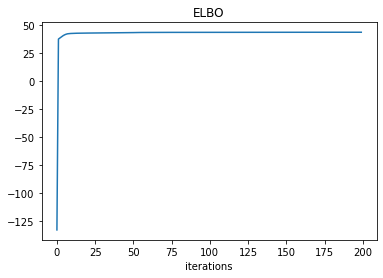

In [10]:
a_tilde, b_tilde, c_tilde, d_tilde, mu_N, Sigma_N, ELBO = VI(Phi, t, a=1e-5, b=1e-5, c=1e-5, d=1e-5, 
                                                              max_iter=200, rtol=1e-2, verbose=True)

import matplotlib.pyplot as plt

plt.plot(ELBO)
plt.title('ELBO')
plt.xlabel('iterations')

The ELBO should be monotonically increasing.

**Posterior predictive distribution**

With this variational inference approach, the posterior predictive distribution is given by:

$$
p(t_{\star} \lvert \mathbf{t}) = \int{p(t_\star \lvert \mathbf{w}, \beta) q(\mathbf{w}) q(\beta) d\mathbf{w} d\beta}.
$$

Unfortunately, this integral is intractable, but it can be reasonably approximated by:

$$
p(t_{\star} \lvert \mathbf{t}) \approx \int{p(t_\star \lvert \mathbf{w}, \hat{\beta}) q(\mathbf{w}) d\mathbf{w}} = \mathcal{N}\left(t ; \boldsymbol\mu_N^\top \boldsymbol\phi(\mathbf{x}_{\star}),\hat{\beta}^{-1} + \boldsymbol\phi(\mathbf{x})^\top \mathbf{\Sigma}_N \boldsymbol\phi(\mathbf{x})\right),
$$

where $\hat{\beta} = \mathbb{E}_{q(\beta)}[\beta] = \tilde{c}/\tilde{d}.$

This posterior predictive ends up to be very similar to equations (16)-(17) in the homework, except that we replaced $\mathbf{m}_N$ by $\boldsymbol\mu_N$, $\mathbf{S}_N$ by $\mathbf{\Sigma}_N $ and $\beta$ by $\hat{\beta}$.

In [11]:
# Test observations
X_test = np.linspace(0, 1, 100).reshape(-1, 1)

# Function values without noise 
y_true = g(X_test, noise_variance=0)
    
# Design matrix of test observations
Phi_test = expand(X_test, bf=polynomial_basis_function, bf_args=range(1, degree + 1))

Text(0.5, 1.0, 'Posterior predictive for the sparse Bayesian LR model')

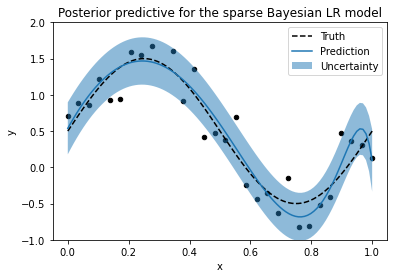

In [12]:
from utils1 import posterior_predictive, plot_data, plot_truth, plot_predictive

y_VI, y_var_VI = posterior_predictive(Phi_test, mu_N, Sigma_N, c_tilde/d_tilde)

plt.figure()
plot_data(X, t)
plot_truth(X_test, y_true)
plot_predictive(X_test, y_VI, np.sqrt(y_var_VI))
plt.ylim(-1.0, 2.0)
plt.legend()
plt.title('Posterior predictive for the sparse Bayesian LR model')

Let's compare with the posterior predictive obtained using the Bayesian linear regression model of the homework.

You first have to complete the ```EM``` function in ```EM.py``` using the code you wrote in the homework notebook. Then, run the following cell.

Convergence after 145 iterations.


Text(0.5, 1.0, 'Posterior predictive for the Bayesian LR model')

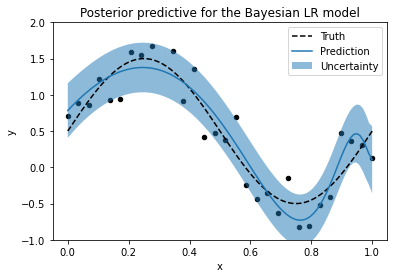

In [13]:
from EM import EM

alpha, beta, m_N, S_N, mlls = EM(Phi, t, rtol=1e-5, verbose=True)
y_EM, y_var_EM = posterior_predictive(Phi_test, m_N, S_N, beta)

plt.figure()
plot_data(X, t)
plot_truth(X_test, y_true)
plot_predictive(X_test, y_EM, np.sqrt(y_var_EM))
plt.ylim(-1.0, 2.0)
plt.legend()
plt.title('Posterior predictive for the Bayesian LR model')

Let's now look at the estimated weights given by the posterior means ```m_N``` and ```mu_N```.

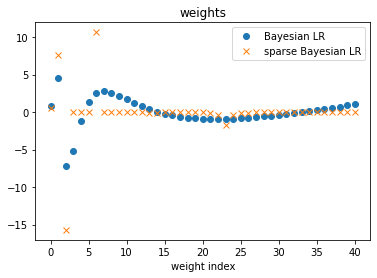

In [14]:
plt.plot(m_N, 'o')
plt.plot(mu_N, 'x')
plt.title("weights")
plt.xlabel("weight index")
plt.legend(['Bayesian LR', 'sparse Bayesian LR'])

Text(0.5, 1.0, 'weights histogram for sparse Bayesian LR')

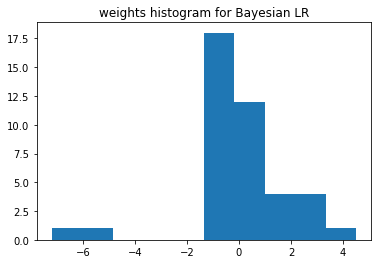

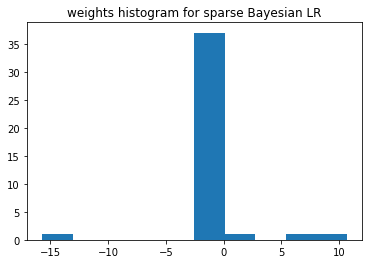

In [15]:
plt.figure()
plt.hist(m_N)
plt.title("weights histogram for Bayesian LR")
plt.figure()
plt.hist(mu_N)
plt.title("weights histogram for sparse Bayesian LR")

With a polynomial model of degree 4, you should not observe much difference between the bayesian LR model (stationary prior for the weights resulting in tracatable posterior inference) and the sparse Bayesian LR model (non-stationary prior for the weights resulting in approximate posterior computation using variational inference). 

**Q3.1** Increase the polynomial degree to 40, re-run the algorithms, what difference do you observe between the two models?

**A3.1** in sparce Bayesian LR we can see that almost all of the weights are null, but in the bayesian LR almost all the weights have values differant than zero.

**Q3.2** In the literature, the model we consider in this notebook (with a non-stationary prior for the regression weights) is referred to as "sparse Baysian linear regression" or "automatic relevance determination". Can you explain why based on what you observe?

**A3.2** Because the sparse bayesian LR we are reducing the dimention of the polynome by annuling the weigths of the degrees that are not necessary to estimate our model.

**Q3.3** The prior over a weight $w_j$ is conditionally Gaussian, with a variance $\alpha_j^{-1}$ following an Inverse-Gamma distribution (or equivalently a precision $\alpha_j$ following a Gamma distribution). We already encountered this hierarchical prior during one of the lectures. What is the marginal distribution of $w_j$ and how does its density differ from the Gaussian distribution?

**A3.3** the marginal distribution of $\mathbf{w}_j$ is a student's distribution. the density diifer from a gaussian distribution because it allows $\mathbf{w}_j$ to take values that are far from the mode.

**Q3.4** If the deterministic hyperparameters $a,b,c,d$ were unknown, how could we estimate them? 

**A3.4** we can estimate the hyperparameters by computing an EM algorithm.